In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import shap
import ast

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/CG_result.csv')
movies_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/movies_metadata.csv")
users_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/user_metadata.csv")

In [ ]:
dataset['recs@5000'] = dataset['recs@5000'].apply(ast.literal_eval)
dataset['movieId'] = dataset['movieId'].apply(ast.literal_eval)

In [ ]:
rating = dataset.explode(['recs@5000'])[['userId', 'recs@5000']]

In [ ]:
movies_metadata['id'] = movies_metadata['id'].astype(str)
users_metadata['userId'] = users_metadata['userId'].astype(str)
rating['userId'] = rating['userId'].astype(str)
rating['recs@5000'] = rating['recs@5000'].astype(str)

In [ ]:
test_negative = rating.merge(users_metadata, on='userId').merge(movies_metadata, left_on='recs@5000', right_on='id')

In [ ]:
dataset

,userId,movieId,rating,len,recs@1000,intersect_len@1000,recall@1000,recs@5000,intersect_len@5000,recall@5000
0,10143,"[150, 1246, 1580, 364, 588, 1073, 4886, 4995, ...","[5.0, 3.5, 4.0, 3.0, 4.0, 3.5, 5.0, 4.0, 4.5, ...",56,"['64501', '422472', '425002', '420967', '42895...",0,0.000000,"[64501, 422472, 425002, 420967, 428950, 429039...",7,0.125000
1,10503,"[1884, 1732, 2692, 4011, 4499, 4886, 1968, 261...","[3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, ...",24,"['67493', '126820', '142051', '67463', '45560'...",2,0.083333,"[67493, 126820, 142051, 67463, 45560, 125336, ...",10,0.416667
2,10802,"[260, 541, 608, 1884, 1961, 223, 750, 265, 562...","[4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, ...",31,"['3024', '3059', '71067', '4196', '2525', '266...",3,0.096774,"[3024, 3059, 71067, 4196, 2525, 2668, 3026, 24...",6,0.193548
3,10843,"[296, 653, 344, 648, 780, 539, 95, 317, 410, 4...","[3.0, 3.0, 5.0, 5.0, 5.0, 3.0, 4.0, 3.0, 3.0, ...",12,"['211672', '339403', '297762', '190605', '3216...",1,0.083333,"[211672, 339403, 297762, 190605, 321612, 67493...",5,0.416667
4,10959,"[150, 165, 318, 380, 457, 480, 593, 292, 377, ...","[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, ...",24,"['211672', '321612', '297762', '67493', '12682...",0,0.000000,"[211672, 321612, 297762, 67493, 126820, 142051...",0,0.000000
...,...,...,...,...,...,...,...,...,...,...
383,9714,"[457, 2692, 1394, 1721, 2011, 1273, 1923, 2140...","[4.0, 5.0, 4.0, 5.0, 3.0, 5.0, 3.0, 3.0, 3.0, ...",12,"['67493', '126820', '142051', '67463', '45560'...",2,0.166667,"[67493, 126820, 142051, 67463, 45560, 125336, ...",8,0.666667
384,9762,"[150, 1246, 2762, 104, 377, 2502, 4995, 454, 3...","[4.0, 3.5, 3.5, 3.5, 3.0, 3.5, 3.5, 3.0, 3.0, ...",19,"['211672', '321612', '297762', '67493', '12682...",0,0.000000,"[211672, 321612, 297762, 67493, 126820, 142051...",1,0.052632
385,983,"[150, 480, 593, 608, 924, 1610, 1961, 1073, 20...","[4.5, 3.5, 4.5, 5.0, 4.0, 4.5, 4.5, 3.0, 4.5, ...",25,"['211672', '321612', '297762', '67493', '12682...",0,0.000000,"[211672, 321612, 297762, 67493, 126820, 19995,...",0,0.000000
386,9906,"[150, 165, 253, 296, 318, 380, 457, 480, 292, ...","[4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, ...",35,"['211672', '67493', '126820', '142051', '32161...",1,0.028571,"[211672, 67493, 126820, 142051, 321612, 297762...",2,0.057143


In [ ]:
test_negative['userId'].nunique()

388

In [ ]:
test_negative.to_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/HR_input_dataset.csv", index=False)

# Load model

In [ ]:
model = CatBoostClassifier()

model.load_model('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/Catboost', format='cbm')

In [ ]:
col_list = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'movie_age', 'production_companies', 'production_countries', 'spoken_languages', 'genres', 'total_movies', 'userAvgRating', 'userAvgBudget', 'userAvgPopularity', 
                            'userAvgMovieAge', 'userAvgRuntime', 'userTopPH', 'userTopGenres']

categorical_col = ['production_companies', 'production_countries', 'spoken_languages', 'genres', 'userTopPH', 'userTopGenres']

test_negative[categorical_col] = test_negative[categorical_col].fillna('other')
test_negative[col_list] = test_negative[col_list].fillna(-1)

prob_score = model.predict_proba(test_negative[col_list])

In [ ]:
test_negative['prediction_score'] = prob_score[:,1]

In [ ]:
test_negative.sort_values(['userId', 'prediction_score'], inplace=True, ascending=False)

In [ ]:
result = test_negative.groupby('userId').agg(movies=('id', list), pred=('prediction_score', list)).reset_index()

In [ ]:
dataset['userId'] = dataset['userId'].astype(str)

In [ ]:
result = dataset[['userId','movieId', 'len', 'recall@5000', 'rating']].merge(result, on='userId')

In [ ]:
MRR_index = [[x.index(ele) + 1 for ele in list(set(x).intersection(set(y)))] for x, y in zip(result['movies'], result['movieId'])]

In [ ]:
result['MRR'] = [1/ele if ele>0 else 0 for ele in [min(ele) if len(ele)>0 else 0 for ele in MRR_index]]

In [ ]:
result['movies'] = result['movies'].apply(lambda x: x[:18])
result['pred'] = result['pred'].apply(lambda x: x[:18])

In [ ]:
result

,userId,movieId,len,recall@5000,rating,movies,pred,MRR
0,10143,"[150, 1246, 1580, 364, 588, 1073, 4886, 4995, ...",56,0.125000,"[5.0, 3.5, 4.0, 3.0, 4.0, 3.5, 5.0, 4.0, 4.5, ...","[323695, 387700, 221917, 37429, 85304, 59126, ...","[0.6379809822552027, 0.6373279436652867, 0.636...",0.008929
1,10503,"[1884, 1732, 2692, 4011, 4499, 4886, 1968, 261...",24,0.416667,"[3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, ...","[72809, 27644, 51359, 41206, 36362, 2969, 1202...","[0.7713761702796924, 0.7325618244500323, 0.727...",0.003484
2,10802,"[260, 541, 608, 1884, 1961, 223, 750, 265, 562...",31,0.193548,"[4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, ...","[8337, 72809, 4327, 211672, 4978, 6715, 116437...","[0.8008633389586134, 0.7966277752814551, 0.782...",0.002681
3,10843,"[296, 653, 344, 648, 780, 539, 95, 317, 410, 4...",12,0.416667,"[3.0, 3.0, 5.0, 5.0, 5.0, 3.0, 4.0, 3.0, 3.0, ...","[211672, 185720, 65216, 245891, 58928, 35568, ...","[0.9526752593438834, 0.9504874536902054, 0.944...",0.000763
4,10959,"[150, 165, 318, 380, 457, 480, 593, 292, 377, ...",24,0.000000,"[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, ...","[51357, 78, 84771, 51359, 27644, 26599, 40629,...","[0.8110628298291427, 0.8094080941185388, 0.790...",0.000000
...,...,...,...,...,...,...,...,...
383,9714,"[457, 2692, 1394, 1721, 2011, 1273, 1923, 2140...",12,0.666667,"[4.0, 5.0, 4.0, 5.0, 3.0, 5.0, 3.0, 3.0, 3.0, ...","[116437, 347328, 105567, 149940, 31035, 177869...","[0.7651751249702241, 0.7474961128017544, 0.686...",0.001678
384,9762,"[150, 1246, 2762, 104, 377, 2502, 4995, 454, 3...",19,0.052632,"[4.0, 3.5, 3.5, 3.5, 3.0, 3.5, 3.5, 3.0, 3.0, ...","[1280, 745, 348893, 2357, 211672, 96821, 11643...","[0.8239465116117067, 0.8161722806270325, 0.799...",0.000405
385,983,"[150, 480, 593, 608, 924, 1610, 1961, 1073, 20...",25,0.000000,"[4.5, 3.5, 4.5, 5.0, 4.0, 4.5, 4.5, 3.0, 4.5, ...","[221917, 84771, 80386, 46744, 213556, 261884, ...","[0.6238474577559507, 0.5856155719749663, 0.561...",0.000000
386,9906,"[150, 165, 253, 296, 318, 380, 457, 480, 292, ...",35,0.057143,"[4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, ...","[1398, 168259, 1669, 271110, 4978, 2064, 4922,...","[0.7107768230098171, 0.6892730733400158, 0.673...",0.015385


In [ ]:
result.to_csv('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/HR_result.csv', index=False)

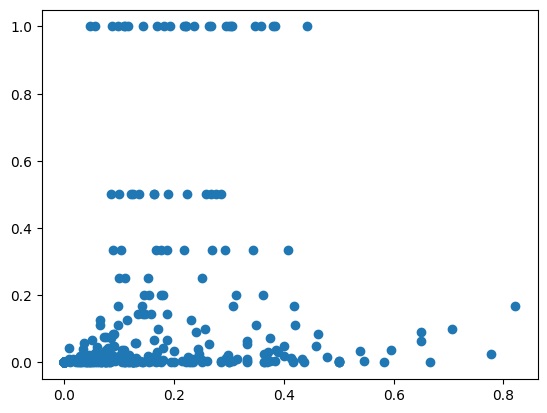

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(result['recall@5000'], result['MRR'])